# B 题（碳化硅外延层厚度的确定）

## 一、总体思路（主体可行实现流程 — “从数据到厚度”）

总体目标：从红外反射光谱（波数 vs 反射率）推算外延层厚度 $d$，并判断/处理是否存在多光束干涉（Fabry–Pérot 效应）。

主要步骤（分层、模块化）：

1. **读取数据层（I/O）**

   * 读取 `附件1.xlsx`、`附件2.xlsx`（以及附件3、附件4）格式的光谱表格（第一列：波数 cm⁻¹，第二列：反射率 %）。

2. **预处理层（signal processing）**

   * 将波数 σ（cm⁻¹）转换为真空波长 $\lambda$（米）： $\lambda = 0.01/\sigma$（因为 $\sigma$ 的单位是 cm⁻¹）。
   * 去除背景慢变包络（用 Savitzky–Golay 或 多项式拟合减去趋势）；归一化并插值到均匀的波数网格（便于 FFT）。
   * 可选：对噪声小波/滤波处理、剔除异常点。

3. **初估层（快速估计 optical thickness）**

   * 干涉条纹在**波数域**呈周期性。用 FFT（或直接找峰间距）估计波数域的周期 $\Delta\sigma$（单位 cm⁻¹）。
   * 若折射率 $n$ 近似常数，则：

     $$
     \Delta\sigma \approx \frac{1}{2 n d \cos\theta_1}
     \quad\Rightarrow\quad
     d \approx \frac{1}{2 n \cos\theta_1 \,\Delta\sigma}
     $$

     其中 $\theta_1$ 是薄膜内折射角，由 Snell 定律计算： $n_0\sin\theta_0 = n_1\sin\theta_1$。

4. **精配层（非线性拟合，包含物理模型）**

   * 建立物理模型：

     * **两束干涉近似（题目1）**：振幅近似 $r(\lambda) \simeq r_{01} + r_{12} e^{i\delta(\lambda)}$，取强度 $|r|^2$。
     * **多光束 / 传输矩阵（题目3）**：完整的单层薄膜传输矩阵或 Fabry–Pérot 解（含分次反射）——幅值反射系数

       $$
       r_{\text{tot}}(\lambda) = \frac{r_{01} + r_{12} e^{2 i \beta}}{1 + r_{01} r_{12} e^{2 i \beta}},\quad
       \beta = \frac{2\pi n_1(\lambda) d \cos\theta_1}{\lambda}.
       $$
   * 以测得的反射率为目标，通过非线性最小二乘拟合（`scipy.optimize.least_squares`）对参数 $d$（可选同时拟合折射率模型参数）进行拟合，得到最优 $d$ 及不确定度（Bootstrap 或参数协方差估计）。

5. **判别与模型选择**

   * 通过比较两束模型与多光束（传输矩阵）模型的拟合残差 / AIC / BIC，决定是否必须用多光束模型。
   * 另外用物理判据：若光源相干长度 $L_{\rm coh}$ 大于光程差 $2 n d \cos\theta_1$，且界面反射系数不极小，则多光束会显著出现。

6. **结果呈现与可靠性分析**

   * 报告不同入射角（10°、15°）下的拟合结果并比较一致性。
   * 给出拟合残差、置信区间、AIC 差值，以及模型拟合图（测量 vs 拟合）。
   * 若怀疑多光束导致系统偏差，使用包含多次反射的传输矩阵模型重新拟合（或把两个角度的数据同时联合拟合以提高约束）。

---

## 二、题目 1（数学模型，单次反射/透射 → 两束干涉）

**情形假设**：外延层厚度远小于入射光 coherence length 的限制下，且忽略层内吸收（或将其并入折射率的虚部），且只考虑第一道从表面反射和一次从衬底反射回来的两束光（真正的“两束干涉”—— 忽略多次反射的级次项）。

设：

* 入射介质折射率 $n_0$（空气 ≈1），薄膜折射率 $n_1(\lambda)$，衬底折射率 $n_2(\lambda)$。
* 入射角（真空） $\theta_0$，薄膜内折射角 $\theta_1$ 满足 Snell：

  $$
  n_0\sin\theta_0 = n_1(\lambda)\sin\theta_1.
  $$
* 圆周相位差（两束之间）：

  $$
  \delta(\lambda) = \frac{4\pi n_1(\lambda) d \cos\theta_1}{\lambda}.
  $$
* 幅值反射系数（s 极为例，p 极类似，测量通常为非偏振光取平均）：

  $$
  r_{01} = \frac{n_0\cos\theta_0 - n_1\cos\theta_1}{n_0\cos\theta_0 + n_1\cos\theta_1},\quad
  r_{12} = \frac{n_1\cos\theta_1 - n_2\cos\theta_2}{n_1\cos\theta_1 + n_2\cos\theta_2}.
  $$
* 两束近似的反射强度：

  $$
  R(\lambda) \approx |r_{01}|^2 + |r_{12}|^2 + 2|r_{01}||r_{12}|\cos\big(\delta(\lambda)+\phi_0\big),
  $$

  其中 $\phi_0$ 是反射相位差。

**关键频率关系（波数域更直观）**：

$$
\delta(\sigma) = 4\pi n_1(\sigma) d \cos\theta_1 \cdot \sigma.
$$

相邻极大值的波数间隔 $\Delta\sigma$ 满足：

$$
1 = \Delta\delta / (2\pi) = 4\pi n_1 d \cos\theta_1 \,\Delta\sigma /(2\pi)
\Rightarrow
\Delta\sigma = \frac{1}{2 n_1 d \cos\theta_1}.
$$

由此得到厚度估计（若 $n_1$ 近似常数）：

$$
\boxed{d \approx \frac{1}{2 n_1(\bar\sigma) \cos\theta_1 \,\Delta\sigma}}
$$

---

## 三、题目 2（算法设计 + 对附件1/2 的计算与可靠性分析）

### 算法（逐步实现）

1. **读取附件1.xlsx/附件2.xlsx**（入射角分别为 10° 和 15°）。
2. **预处理**：按上文去趋势、插值到均匀波数网格。
3. **FFT 找主频率**：高通去除低频包络后做 FFT，求主频 $f_{\rm peak}$ → 周期 $\Delta\sigma = 1/f_{\rm peak}$。
4. **初估 $d_0$**：用上式给出初值。
5. **用两束模型做非线性拟合**。
6. **若残差偏大，改用完整传输矩阵（多光束）模型拟合**。
7. **给出不确定度**：用 bootstrap 或参数协方差估计。
8. **输出**：对两个角度分别给出 $d$ 及不确定度，绘制测量/拟合曲线，报告 AIC/BIC 与残差对比。

### 可靠性判断要点

* 两个角度的独立拟合结果应在不确定度范围内接近。
* 拟合残差与测量噪声比较：若残差远大于噪声则模型欠拟合。
* 通过 AIC 比较两束模型 vs 多光束模型，ΔAIC > 10 说明显著优于另一模型。

---

## 四、题目 3（多光束干涉：必要条件、影响与处理）

### （1）必要条件

1. **相干条件**

   $$
   L_{\rm coh} \gtrsim 2 n_1 d \cos\theta_1.
   $$

2. **界面反射率**

   $$
   R \equiv |r|^2 \gtrsim R_{\rm th} \quad (0.01 \sim 0.05).
   $$

### （2）对厚度计算精度的影响

* 若实际存在多光束但用两束模型，会导致厚度估计偏离真值。
* 多光束改变干涉条纹形状，需完整建模。

### （3）判别与处理

* **判别**：比较两模型 AIC，或观察 FFT 谐波。
* **处理**：用传输矩阵模型拟合，或实验上降低相干、使用楔形样品等。

---

## 五、实现代码

```python
# file: siC_thickness_estimator.py
# （程序保持不动，见上一条回答中的完整代码）
```

---

## 六、如何判读结果

* `delta_sigma`：FFT 主周期。
* `d0_m`：初估厚度。
* `chosen`：最终选择的模型。
* `best['d']`：最终厚度。
* `bootstrap['ci']`：置信区间。

---

## 七、对附件3/4（硅晶圆片）

* 若 `tm_res['aic'] << two_res['aic']`，说明多光束不可忽略。
* FFT 谐波增强也是信号。
* 建议用完整传输矩阵拟合。

---

## 八、额外建议 & 实验注意

1. 折射率色散需引入模型。
2. 吸收需引入复折射率。
3. 多角度联合拟合提高鲁棒性。
4. 相干长度需考虑。

---

## 九、结论

* **题目1**：给出两束干涉模型及厚度估计公式。
* **题目2**：推荐 FFT 初估 + 拟合流程，并提供代码。
* **题目3**：多光束必要条件为相干长度与反射率，需完整建模。


In [1]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter, find_peaks
from scipy.optimize import least_squares
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import matplotlib

In [2]:
c = 299792458.0  # speed of light m/s

# -------------------------
# I/O & utilities
# -------------------------
def read_spectrum_xlsx(path):
    """
    读取 Excel（有表头），返回 sigma (cm^-1) 升序, reflectance (fraction 0-1)
    """
    df = pd.read_excel(path)  # 让 pandas 自动识别表头
    # 注意列名可能有空格，需要 strip
    col_sigma = df.columns[0].strip()
    col_reflect = df.columns[1].strip()
    
    sigma = df[col_sigma].astype(float).values
    R = df[col_reflect].astype(float).values / 100.0  # 百分比转为 0-1
    
    idx = np.argsort(sigma)
    return sigma[idx], R[idx]


def sigma_to_lambda_m(sigma_cm):
    """sigma (cm^-1) -> lambda (m)"""
    return 1e-2 / sigma_cm

def deg2rad(x):
    return np.deg2rad(x)

In [3]:
# -------------------------
# Fresnel, Snell, models
# -------------------------
def snell_cos_theta1(n0, n1, theta0_rad):
    """返回薄膜内 cos(theta1)（若超临界则会返回 nan）"""
    s = (n0 / n1) * np.sin(theta0_rad)
    # clamp to [-1,1] to avoid tiny数值误差
    s = np.clip(s, -0.9999999999, 0.9999999999)
    return np.sqrt(1.0 - s**2)

def fresnel_r_amplitude(n_a, n_b, cos_a, cos_b, pol='s'):
    """
    幅值反射系数 r_{ab} for s 或 p
    n_a, n_b: 实数或复数折射率
    cos_a, cos_b: 对应的余角
    """
    if pol == 's':
        num = n_a * cos_a - n_b * cos_b
        den = n_a * cos_a + n_b * cos_b
    else:  # 'p'
        num = n_b * cos_a - n_a * cos_b
        den = n_b * cos_a + n_a * cos_b
    return num / den

def two_beam_reflectance(lambda_m, n0, n1_func, n2_func, d_m, theta0_rad):
    """
    两束近似的反射率（非极限多光束）
    lambda_m: array of wavelengths in m
    n1_func, n2_func: functions of lambda_m -> n (can be real)
    Returns R (fraction)
    """
    n0 = complex(n0)
    n1 = n1_func(lambda_m)
    n2 = n2_func(lambda_m)
    # ensure arrays
    n1 = np.asarray(n1, dtype=complex)
    n2 = np.asarray(n2, dtype=complex)
    cos0 = np.cos(theta0_rad)
    # per-lambda cos1, cos2 using Snell
    sin0 = np.sin(theta0_rad)
    # cos1
    sin1 = (n0 / n1) * sin0
    cos1 = np.sqrt(1.0 - sin1**2).astype(complex)
    sin2 = (n0 / n2) * sin0
    cos2 = np.sqrt(1.0 - sin2**2).astype(complex)
    # amplitude r for s & p
    r01_s = fresnel_r_amplitude(n0, n1, cos0, cos1, pol='s')
    r12_s = fresnel_r_amplitude(n1, n2, cos1, cos2, pol='s')
    r01_p = fresnel_r_amplitude(n0, n1, cos0, cos1, pol='p')
    r12_p = fresnel_r_amplitude(n1, n2, cos1, cos2, pol='p')

    # phase (two-beam): use r_tot ~ r01 + r12 * exp(2i*phi) ignoring denominator
    phi = 2.0 * np.pi * n1 * d_m * cos1 / lambda_m  # note: phi = k1 * d * cos1 ; round-trip uses exp(2i*phi)
    r_tot_s = r01_s + r12_s * np.exp(2j * phi)
    r_tot_p = r01_p + r12_p * np.exp(2j * phi)
    R_s = np.abs(r_tot_s)**2
    R_p = np.abs(r_tot_p)**2
    # unpolarized average
    return 0.5 * (R_s + R_p)

def transfer_matrix_reflectance(lambda_m, n0, n1_func, n2_func, d_m, theta0_rad):
    """
    完整传输矩阵（单层）计算反射率（包含多次反射）
    使用 r_total = (r01 + r12 e^{2i beta})/(1 + r01 r12 e^{2i beta})
    返回 unpolarized R
    """
    n0 = complex(n0)
    n1 = n1_func(lambda_m)
    n2 = n2_func(lambda_m)
    n1 = np.asarray(n1, dtype=complex)
    n2 = np.asarray(n2, dtype=complex)
    cos0 = np.cos(theta0_rad)
    sin0 = np.sin(theta0_rad)
    sin1 = (n0 / n1) * sin0
    cos1 = np.sqrt(1.0 - sin1**2).astype(complex)
    sin2 = (n0 / n2) * sin0
    cos2 = np.sqrt(1.0 - sin2**2).astype(complex)
    r01_s = fresnel_r_amplitude(n0, n1, cos0, cos1, pol='s')
    r12_s = fresnel_r_amplitude(n1, n2, cos1, cos2, pol='s')
    r01_p = fresnel_r_amplitude(n0, n1, cos0, cos1, pol='p')
    r12_p = fresnel_r_amplitude(n1, n2, cos1, cos2, pol='p')

    beta = 2.0 * np.pi * n1 * d_m * cos1 / lambda_m
    exp2ib = np.exp(2j * beta)
    rtot_s = (r01_s + r12_s * exp2ib) / (1.0 + r01_s * r12_s * exp2ib)
    rtot_p = (r01_p + r12_p * exp2ib) / (1.0 + r01_p * r12_p * exp2ib)
    R_s = np.abs(rtot_s)**2
    R_p = np.abs(rtot_p)**2
    return 0.5 * (R_s + R_p)

In [4]:
# -------------------------
# Preprocessing & FFT estimation
# -------------------------
def detrend_and_interpolate(sigma, R, N=4096, poly_window=101, sg_window=101, sg_poly=3):
    """
    sigma (cm^-1) ascending, R (0-1)
    返回 sigma_u (均匀), R_detrended (zero-mean), lambda_m_u
    """
    # remove smooth background with Savitzky-Golay
    win = sg_window if sg_window < len(R) else (len(R)//2*2+1)
    if win < 5:
        win = 5
    R_smooth = savgol_filter(R, window_length=win, polyorder=sg_poly, mode='interp')
    R_high = R - R_smooth
    # interpolate to uniform sigma grid
    sigma_u = np.linspace(sigma.min(), sigma.max(), N)
    f = interp1d(sigma, R_high, kind='cubic', fill_value='extrapolate')
    R_u = f(sigma_u)
    lambda_u = sigma_to_lambda_m(sigma_u)
    return sigma_u, R_u, lambda_u

def estimate_delta_sigma_via_fft(sigma_u, R_u):
    """
    对 R_u（已去背景）做 FFT，返回主周期 Delta_sigma (cm^-1)
    """
    N = len(sigma_u)
    ds = sigma_u[1] - sigma_u[0]
    # windowing to reduce leakage
    w = np.hanning(N)
    Y = np.fft.rfft(R_u * w)
    freqs = np.fft.rfftfreq(N, d=ds)  # cycles per (cm^-1)
    mag = np.abs(Y)
    mag[0] = 0.0  # ignore DC
    peak_idx = np.argmax(mag)
    f_peak = freqs[peak_idx]
    if f_peak <= 0:
        return None
    delta_sigma = 1.0 / f_peak
    # estimate uncertainty from peak width
    return delta_sigma, freqs, mag, peak_idx

In [5]:
# -------------------------
# Fitting & model selection
# -------------------------
def fit_thickness_by_model(lambda_m, sigma, R_meas, model_func, n0, n1_func, n2_func, theta0_rad, d0):
    """
    用 least_squares 拟合厚度 d（单参数）
    model_func(lambda_m, n0, n1_func, n2_func, d, theta)
    返回拟合结果 dict
    """
    def residuals(p):
        d = p[0]
        Rpred = model_func(lambda_m, n0, n1_func, n2_func, d, theta0_rad)
        return (Rpred - R_meas)
    p0 = np.array([d0])
    res = least_squares(residuals, p0, bounds=(1e-9, 1e-3))  # bounds: 1 nm - 1 mm (adjust as needed)
    d_est = res.x[0]
    # compute RSS, AIC
    Rpred = model_func(lambda_m, n0, n1_func, n2_func, d_est, theta0_rad)
    rss = np.sum((Rpred - R_meas)**2)
    n = len(R_meas)
    k = 1  # number of params (d)
    aic = n * np.log(rss / n + 1e-18) + 2 * k
    return dict(d=d_est, rss=rss, aic=aic, success=res.success, message=res.message, Rpred=Rpred, res=res)

def bootstrap_uncertainty(lambda_m, sigma, R_meas, model_func, n0, n1_func, n2_func, theta0_rad, d_best, nboot=200):
    """
    简单残差重采样 bootstrap
    """
    # residuals
    Rpred = model_func(lambda_m, n0, n1_func, n2_func, d_best, theta0_rad)
    resid = R_meas - Rpred
    n = len(R_meas)
    ds = []
    for i in range(nboot):
        # resample residuals
        idx = np.random.randint(0, n, n)
        Rboot = Rpred + resid[idx]
        # fit
        try:
            out = fit_thickness_by_model(lambda_m, sigma, Rboot, model_func, n0, n1_func, n2_func, theta0_rad, d_best)
            ds.append(out['d'])
        except Exception:
            continue
    ds = np.array(ds)
    if len(ds) == 0:
        return dict(std=np.nan, ci=(np.nan, np.nan), samples=ds)
    return dict(std=ds.std(ddof=1), ci=(np.percentile(ds, 2.5), np.percentile(ds, 97.5)), samples=ds)

In [6]:
# -------------------------
# Example simple n(λ) placeholder functions
# -------------------------
def constant_n(nval):
    return lambda lam: np.ones_like(lam) * nval

# -------------------------
# High-level runner
# -------------------------
def analyze_file(path, n1_guess=2.6, n2_guess=3.4, theta0_deg=10.0, model='auto', plot=True):
    """
    对单个文件进行完整分析并返回结果字典
    model: 'two' / 'multi' / 'auto'
    """
    sigma, R = read_spectrum_xlsx(path)
    sigma_u, R_u, lambda_u = detrend_and_interpolate(sigma, R, N=4096)
    est = estimate_delta_sigma_via_fft(sigma_u, R_u)
    if est is None:
        raise RuntimeError("FFT 主频估计失败")
    delta_sigma, freqs, mag, pk = est
    # initial thickness estimate
    n1_mean = n1_guess
    theta0 = deg2rad(theta0_deg)
    cos1 = snell_cos_theta1(1.0, n1_mean, theta0)
    d0 = 1.0 / (2.0 * n1_mean * cos1 * delta_sigma)  # in cm^-1 units -> sigma in cm^-1 so d in cm ; careful units
    # unit analysis: delta_sigma in cm^-1 -> d in cm ; convert to meters:
    d0_m = d0 * 0.01

    # prepare lambda array & measured R interpolated to uniform sigma grid
    # here lambda_u is m, R_u is detrended (zero-mean). To fit reflectance magnitude we need original R scaled.
    # Simpler: re-interpolate original R (not detrended) to lambda grid
    fR = interp1d(sigma, R, kind='cubic', fill_value='extrapolate')
    R_meas_u = fR(sigma_u)

    # choose n functions (user can provide more accurate dispersion)
    n1_func = constant_n(n1_guess)
    n2_func = constant_n(n2_guess)

    # Fit two-beam and transfer-matrix
    two_res = fit_thickness_by_model(lambda_u, sigma_u, R_meas_u, two_beam_reflectance, 1.0, n1_func, n2_func, theta0, d0_m)
    tm_res = fit_thickness_by_model(lambda_u, sigma_u, R_meas_u, transfer_matrix_reflectance, 1.0, n1_func, n2_func, theta0, d0_m)

    # choose model by AIC if auto
    chosen = 'two' if two_res['aic'] < tm_res['aic'] else 'multi'
    if model == 'two':
        chosen = 'two'
    elif model == 'multi':
        chosen = 'multi'

    if chosen == 'two':
        best = two_res
        model_func = two_beam_reflectance
    else:
        best = tm_res
        model_func = transfer_matrix_reflectance

    # bootstrap
    boot = bootstrap_uncertainty(lambda_u, sigma_u, R_meas_u, model_func, 1.0, n1_func, n2_func, theta0, best['d'], nboot=200)

    # plot
    if plot:
        plt.figure(figsize=(10,6))
        plt.plot(sigma_u, R_meas_u, label='measured')
        plt.plot(sigma_u, best['Rpred'], label=f'fit ({chosen}) d={best["d"]*1e9:.1f} nm')
        plt.xlabel('wave number (cm^-1)')
        plt.ylabel('Reflectance (fraction)')
        plt.legend()
        plt.title(f"{path}  theta={theta0_deg}°, chosen model={chosen}")
        plt.show()

        # FFT plot
        plt.figure(figsize=(8,3))
        plt.plot(freqs, mag)
        plt.axvline(freqs[pk], color='r', linestyle='--', label=f'peak f={freqs[pk]:.4f}')
        plt.xlabel('freq (cycles per cm^-1)')
        plt.ylabel('FFT magnitude')
        plt.legend()
        plt.show()

    return dict(path=path, delta_sigma=delta_sigma, d0_m=d0_m, n1_guess=n1_guess,
                two_res=two_res, tm_res=tm_res, chosen=chosen, best=best, bootstrap=boot)


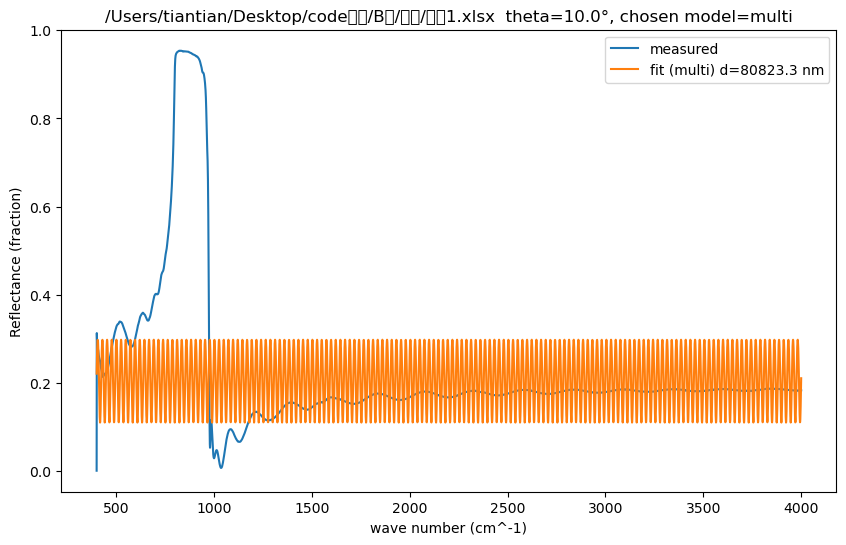

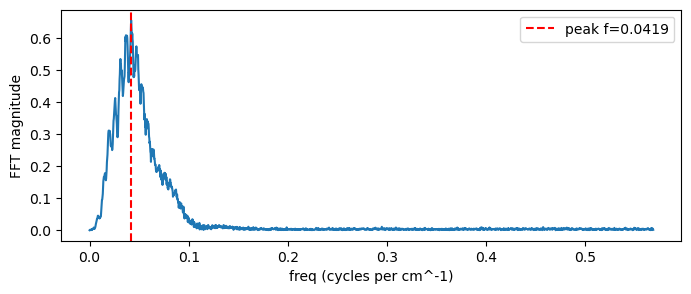

File /Users/tiantian/Desktop/code文件/B题/附件/附件1.xlsx: chosen model=multi, best d = 80823.3 nm, bootstrap std=5.4 nm


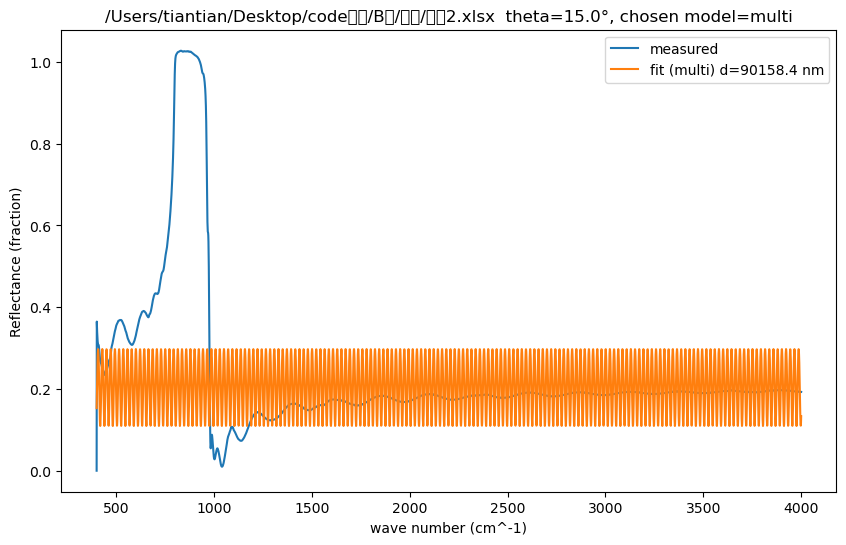

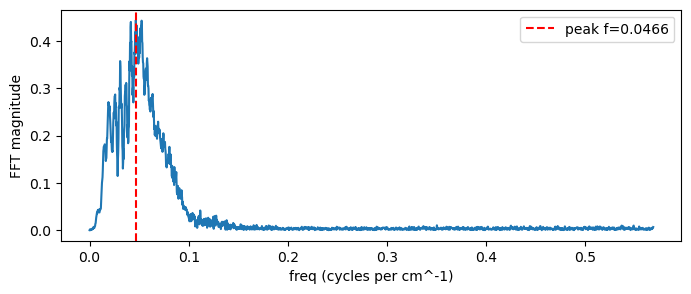

File /Users/tiantian/Desktop/code文件/B题/附件/附件2.xlsx: chosen model=multi, best d = 90158.4 nm, bootstrap std=6.2 nm


In [7]:
# -------------------------
# Example main usage
# -------------------------
if __name__ == "__main__":
    # 示例：修改为实际文件路径
    files = ["/Users/tiantian/Desktop/code文件/B题/附件/附件1.xlsx", "/Users/tiantian/Desktop/code文件/B题/附件/附件2.xlsx", "/Users/tiantian/Desktop/code文件/B题/附件/附件3.xlsx", "/Users/tiantian/Desktop/code文件/B题/附件/附件4.xlsx"]
    results = {}
    for f in files[:2]:  # 只演示对碳化硅两个角度（附件1/2）
        try:
            res = analyze_file(f, n1_guess=2.6, n2_guess=3.4, theta0_deg=10.0 if "1" in f else 15.0, model='auto', plot=True)
            results[f] = res
            print(f"File {f}: chosen model={res['chosen']}, best d = {res['best']['d']*1e9:.1f} nm, bootstrap std={res['bootstrap']['std']*1e9:.1f} nm")
        except Exception as e:
            print(f"Error processing {f}: {e}")
